# NASDAQ Securities (Stocks and ETFs) Exploration Dashboard

Dashboard that explores:

* Several features of all stocks listed on the NASDAQ stock exchange
* Detailed visualizations for user-selected stocks in a user-selected time period

## Dataset Overview

The original idea started from the [Kaggle Stock Market Dataset](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset/data) (not up to date). It is actually two datasets:

The first one, taken from [nasdaqtrader.com](http://nasdaqtrader.com), is the [list of all NASDAQ securities](https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqtraded.txt) with some metadata about each one.

The second dataset is huge number of generated CSV files with time series data of each individual stock or ETF's daily prices. The retrieval method is using Yahoo Finance via the *yfinance* python package. 

In the process of developing this dashboard, this approach proved ineffective and doesn't map properly to its purpose. As the user of this dashboard can select a security and time period for analysis, it makes no sense to download all ~12 000 securities in advance for all years since inception. This takes a lot of time and would result in gigabytes of useless data.

In the final design, only the full list of NASDAQ symbols and relevant metadata is downloadad and analyzed in the first part of the dashboard. Then, based on user's input data, the *yfinance* python package is used to interactively download only the needed data for the selected list of securities and the selected time period.

## Data Columns

### nasdaqtraded.txt

**Nasdaq Traded** - if the symbol is traded in NASDAQ

**Symbol** - ticker of the stock/ETF

**Security Name** - full name of the stock/ETF

**Listing Exchange** - the exchange where the stock/ETF is traded (to be explored)

**Market Category** - market category (to be explored)

**ETF** - Y for ETF, N for stock

**Round Lot Size** - round lot size

**Test Issue** - whether the stock/ETF is a test issue

**Financial Status** - finacial status (to be explored)

**CQS Symbol** - CQS Symbol

**NASDAQ Symbol** - NASDAQ Symbol

**NextShares** - whether the stock/ETF is a NextShares product

### Each Stock or ETF

**Date** - specifies trading date

**Open** - opening price

**High** - maximum price during the day

**Low** - minimum price during the day

**Close** - close price adjusted for splits

**Adj Close** - adjusted close price adjusted for both dividends and splits

**Volume** - the number of shares that changed hands during a given day

## Dataset Statistics

Let's first examine some interesting statistics from the [online list](https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqtraded.txt) of all NASDAQ securities. A locally saved version from 2 August 2024 is used.

## Install required libraries

Use your favorite way (conda/pip) to install:

nbformat pandas matplotlib seaborn plotly ipywidgets yfinance TA-Lib

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import talib  # Technical Analysis Library, use "conda/pip install TA-Lib", not "talib"

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output

from datetime import date

import yfinance as yf
import os, contextlib

%matplotlib inline

In [2]:
securities = pd.read_csv("nasdaqtraded.txt", sep='|')
securities

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAA,Alternative Access First Priority CLO Bond ETF,P,,Y,100.0,N,NaN,AAA,AAA,N
3,Y,AAAU,Goldman Sachs Physical Gold ETF Shares,Z,,Y,100.0,N,NaN,AAAU,AAAU,N
4,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,D,NaN,AACG,N
...,...,...,...,...,...,...,...,...,...,...,...,...
11073,Y,ZXZZT,NASDAQ TEST STOCK,Q,G,,100.0,Y,N,NaN,ZXZZT,N
11074,Y,ZYME,Zymeworks Inc. - Common Stock,Q,Q,N,100.0,N,N,NaN,ZYME,N
11075,Y,ZYXI,"Zynex, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,ZYXI,N
11076,Y,ZZZ,Cyber Hornet S&P 500 and Bitcoin 75/25 Strateg...,Q,G,Y,100.0,N,N,NaN,ZZZ,N


In [3]:
etfs = securities[securities['ETF'] == 'Y']
stocks = securities[securities['ETF'] == 'N']
nasdaq_traded = securities[securities['Nasdaq Traded'] == 'Y']
symbol_nans = securities[securities['Symbol'].isna()]
print('ETFs:', len(etfs))
print('Stocks:', len(stocks))
print('NASDAQ Traded:', len(nasdaq_traded))
print('Total:', len(securities))

print('Symbol NaNs:', len(symbol_nans))
print('Listing Exchange Unique Values:', securities['Listing Exchange'].unique())
print('Market Category Unique Values:', securities['Market Category'].unique())
print('Round Lot Size Unique Values:', securities['Round Lot Size'].unique())
print('Test Issue Unique Values:', securities['Test Issue'].unique())
print('Financial Status Unique Values:', securities['Financial Status'].unique())
print('NextShares Unique Values:', securities['NextShares'].unique())

ETFs: 3612
Stocks: 7457
NASDAQ Traded: 11076
Total: 11078
Symbol NaNs: 2
Listing Exchange Unique Values: ['N' 'P' 'Z' 'Q' 'A' 'V' nan]
Market Category Unique Values: [' ' 'G' 'S' 'Q' nan]
Round Lot Size Unique Values: [100.  10.   1.  nan]
Test Issue Unique Values: ['N' 'Y' nan]
Financial Status Unique Values: [nan 'D' 'N' 'E' 'H']
NextShares Unique Values: ['N' nan]


## [Unique Values Map](https://www.nasdaqtrader.com/Trader.aspx?id=SymbolDirDefs)

Listing Exchange:

* N: New York Stock Exchange (NYSE)
* A: NYSE MKT
* P: NYSE ARCA
* Q: NASDAQ Global Select Market
* Z: BATS Global Markets
* V: Investors' Exchange, LLC (IEXG)

Market Category:

* Q: NASDAQ Global Select MarketSM
* G: NASDAQ Global MarketSM
* S: NASDAQ Capital Market

Financial Status:

* N: Normal (No issues)
* D: Deficient (Company is not meeting listing requirements)
* E: Delinquent (Company has failed to file reports on time)
* H: Deficient and Delinquent

## Data Cleaning

We can draw some conclusions from the data analysis so far:

* 2 securities have *NaN* for symbol. Let's remove them.
* 2 securities are not NASDAQ traded (11078 vs 11076). Let's remove them and let's drop the column.
* Test issues of securities are not interesting, so let's filter them and then drop the column.
* NextShares products are not relevant for this analysis, so let's drop the column.
* Round Lot Size is the standard trading unit, i.e. minimum of 10 or 100 shares. This information is not useful for this analysis, so let's drop the column.
* Columns CQS Symbol and NASDAQ Symbol are also not needed, so let's frop them.

Also, let's:

* Replace all *NaN*s from *Listing Exchange* column with *N/A* (not available)
* Replace all empty symbols and *NaN*s in the *Market Category* column with *N/A* (not available)
* Replace all *NaN*s in *Financial Status* column with *N/A* (not available)

In [4]:
# Drop the rows with NaNs in the Symbol column
securities = securities.dropna(subset=['Symbol'])

# Leave only the securities that are traded on NASDAQ
securities = securities[securities['Nasdaq Traded'] == 'Y']

# Leave only the securities that are not test issues
securities = securities[securities['Test Issue'] == 'N']

# Drop several columns that are not needed
securities = securities.drop(['Nasdaq Traded', 'Round Lot Size', 'Test Issue', 'NextShares', 'CQS Symbol', 'NASDAQ Symbol'], axis=1)

# Listing Exchange Unique Values: ['N' 'P' 'Z' 'Q' 'A' 'V' nan]
securities['Listing Exchange'] = securities['Listing Exchange'].fillna('N/A')

# Market Category Unique Values: [' ' 'G' 'S' 'Q' nan]
securities['Market Category'] = securities['Market Category'].fillna('N/A')
securities['Market Category'] = securities['Market Category'].replace(' ', 'N/A')

# Financial Status Unique Values: [nan 'D' 'N' 'E' 'H']
securities['Financial Status'] = securities['Financial Status'].fillna('N/A')


In [5]:
etfs = securities[securities['ETF'] == 'Y']
stocks = securities[securities['ETF'] == 'N']
print('ETFs:', len(etfs))
print('Stocks:', len(stocks))
print('Total:', len(securities))

print('Listing Exchange Unique Values:', securities['Listing Exchange'].unique())
print('Market Category Unique Values:', securities['Market Category'].unique())
print('Financial Status Unique Values:', securities['Financial Status'].unique())

ETFs: 3612
Stocks: 7431
Total: 11043
Listing Exchange Unique Values: ['N' 'P' 'Z' 'Q' 'A']
Market Category Unique Values: ['N/A' 'G' 'S' 'Q']
Financial Status Unique Values: ['N/A' 'D' 'N' 'E' 'H']


In [6]:
securities

,Symbol,Security Name,Listing Exchange,Market Category,ETF,Financial Status
0,A,"Agilent Technologies, Inc. Common Stock",N,N/A,N,N/A
1,AA,Alcoa Corporation Common Stock,N,N/A,N,N/A
2,AAA,Alternative Access First Priority CLO Bond ETF,P,N/A,Y,N/A
3,AAAU,Goldman Sachs Physical Gold ETF Shares,Z,N/A,Y,N/A
4,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,D
...,...,...,...,...,...,...
11066,ZVSA,"ZyVersa Therapeutics, Inc. - Common Stock",Q,S,N,N
11069,ZWS,Zurn Elkay Water Solutions Corporation Common ...,N,N/A,N,N/A
11074,ZYME,Zymeworks Inc. - Common Stock,Q,Q,N,N
11075,ZYXI,"Zynex, Inc. - Common Stock",Q,Q,N,N


## Visualizations

### Listing Exchange

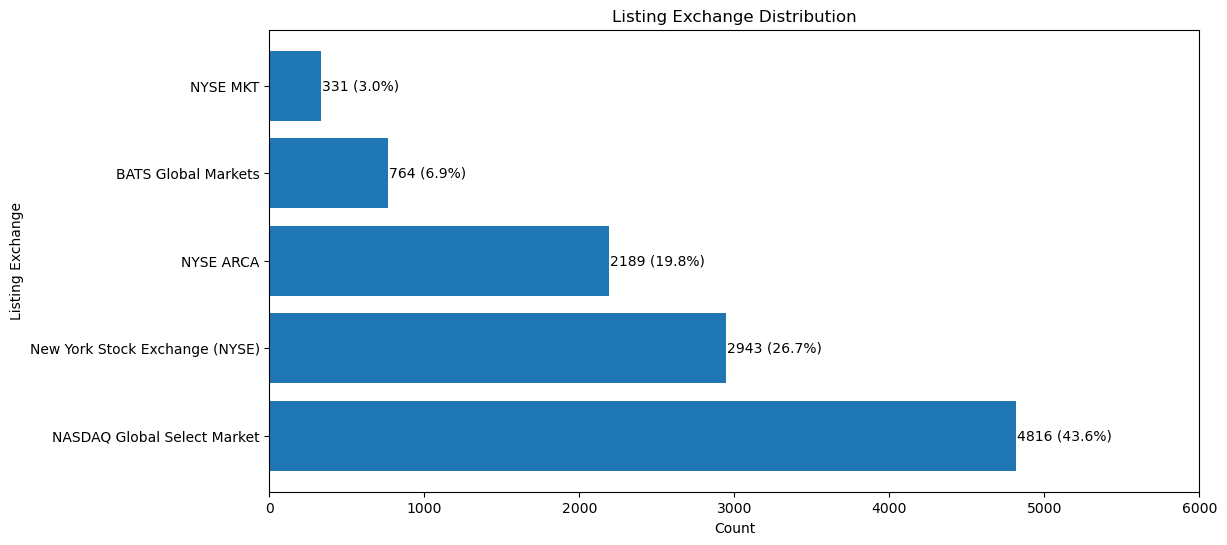

In [7]:
status_mapping = {
    'N': 'New York Stock Exchange (NYSE)',
    'A': 'NYSE MKT',
    'P': 'NYSE ARCA',
    'Q': 'NASDAQ Global Select Market',
    'Z': 'BATS Global Markets',
    'V': 'Investors Exchange, LLC (IEXG)'
}

# Count the occurrences of each financial status
status_counts = securities['Listing Exchange'].value_counts()

# Calculate the percentage of each listing exchange
total = status_counts.sum()
percentages = (status_counts / total) * 100
status_labels = [status_mapping[label] for label in status_counts.index]

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.barh(status_labels, status_counts)
ax.set_xlim(0, 6000)

for bar, count, percentage in zip(bars, status_counts, percentages):
    width = bar.get_width()
    ax.text(width + 10,  # Add some padding between the end of the bar and the text
            bar.get_y() + bar.get_height() / 2,
            f'{count} ({percentage:.1f}%)',
            va='center', ha='left')


ax.set_xlabel('Count')
ax.set_ylabel('Listing Exchange')
plt.title('Listing Exchange Distribution')
plt.show()

### Market Category

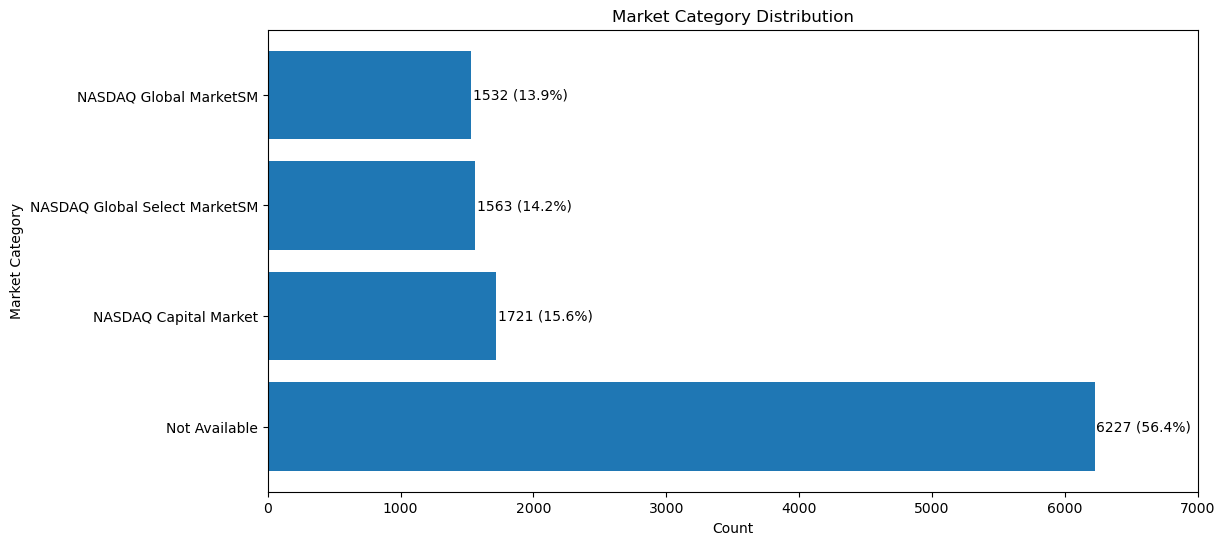

In [8]:
status_mapping = {
    'Q': 'NASDAQ Global Select MarketSM',
    'G': 'NASDAQ Global MarketSM',
    'S': 'NASDAQ Capital Market',
    'N/A': 'Not Available'
}

# Count the occurrences of each market category
status_counts = securities['Market Category'].value_counts()

# Calculate the percentage of each market category
total = status_counts.sum()
percentages = (status_counts / total) * 100
status_labels = [status_mapping[label] for label in status_counts.index]

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.barh(status_labels, status_counts)
ax.set_xlim(0, 7000)

for bar, count, percentage in zip(bars, status_counts, percentages):
    width = bar.get_width()
    ax.text(width + 10,  # Add some padding between the end of the bar and the text
            bar.get_y() + bar.get_height() / 2,
            f'{count} ({percentage:.1f}%)',
            va='center', ha='left')


ax.set_xlabel('Count')
ax.set_ylabel('Market Category')
plt.title('Market Category Distribution')
plt.show()

### Financial Status

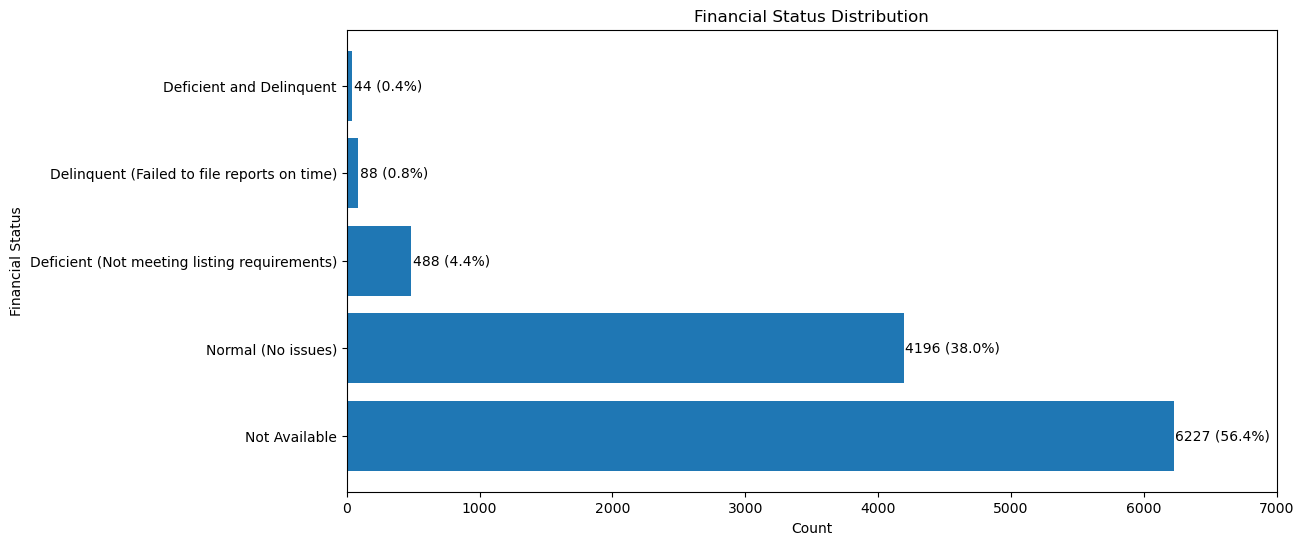

In [9]:
status_mapping = {
    'N': 'Normal (No issues)',
    'D': 'Deficient (Not meeting listing requirements)',
    'E': 'Delinquent (Failed to file reports on time)',
    'H': 'Deficient and Delinquent',
    'N/A': 'Not Available'
}

# Count the occurrences of each financial status
status_counts = securities['Financial Status'].value_counts()

# Calculate the percentage of each financial status
total = status_counts.sum()
percentages = (status_counts / total) * 100
status_labels = [status_mapping[label] for label in status_counts.index]

fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.barh(status_labels, status_counts)
ax.set_xlim(0, 7000)

for bar, count, percentage in zip(bars, status_counts, percentages):
    width = bar.get_width()
    ax.text(width + 10,  # Add some padding between the end of the bar and the text
            bar.get_y() + bar.get_height() / 2,
            f'{count} ({percentage:.1f}%)',
            va='center', ha='left')


ax.set_xlabel('Count')
ax.set_ylabel('Financial Status')
plt.title('Financial Status Distribution')
plt.show()

## Individual Securities Analysis

Now let's analyze individual securities. To do this, first a relevant function will be defined. It will be used below.

In [10]:
def download_prices_of_securities(tickers, start, end):
    ticker_to_stock_prices = {}  # Dictionary to store the data. Key: ticker, Value: Pandas DataFrame from yfinance
    print("Downloading data...")
    # force silencing the verbose API
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull):
            for ticker in tickers:
                data = yf.download(ticker, start=start, end=end, progress=False)
                data = data.reset_index() # Do not use the Date as the index
                ticker_to_stock_prices[ticker] = data
    print("Data downloaded.")
    return ticker_to_stock_prices

### Visualization Functions

The next functions will accept the *ticker_to_stock_prices* dictionary with keys tickers and values the data from yfinance.

They will be executed at the bottom of the notebook.

In [11]:
def plot_price_trends(ticker_to_stock_prices):
    for ticker, df in ticker_to_stock_prices.items():
        fig, ax1 = plt.subplots(figsize=(14, 7))

        ax1.plot(df['Date'], df['Close'], color='blue', label='Close Price')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Close Price')
        ax1.tick_params(axis='y')

        ax2 = ax1.twinx()
        ax2.bar(df['Date'], df['Volume'], color='gray', alpha=0.3, label='Volume')
        ax2.set_ylabel('Volume')
        ax2.tick_params(axis='y')

        plt.title(f'Stock Data for {ticker}')
        fig.tight_layout() 
        plt.show()

In [12]:
def plot_combined_price_trends(ticker_to_stock_prices):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    colors = plt.cm.tab10.colors
    color_idx = 0

    ax2 = ax1.twinx()
    for ticker, df in ticker_to_stock_prices.items():
        df = df.reset_index()

        color = colors[color_idx % len(colors)]
        color_idx += 1

        ax1.plot(df['Date'], df['Close'], label=f'{ticker} Close Price', color=color)
        ax2.bar(df['Date'], df['Volume'], label=f'{ticker} Volume', color=color, alpha=0.3)

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price')
    ax2.set_ylabel('Volume')
    plt.title('Combined Stock Data for All Tickers')

    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    lines, labels = ax1.get_legend_handles_labels()
    bars, bar_labels = ax2.get_legend_handles_labels()
    ax1.legend(lines + bars, labels + bar_labels, loc='upper left')

    fig.tight_layout()  # To make sure the labels and titles fit into the plot area
    plt.show()

In [13]:
def create_candlestick_chart(df, ticker):
    fig = go.Figure(data=[go.Candlestick(
        x=df['Date'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name=ticker
    )])

    fig.update_layout(
        title=f'{ticker} Candlestick Chart',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False
    )

    fig.show()

def plot_candlestick_charts(ticker_to_stock_prices):
    for ticker, df in ticker_to_stock_prices.items():
        create_candlestick_chart(df, ticker)

In [14]:
def plot_correlation_analysis(ticker_to_stock_prices):
    close_prices = pd.DataFrame()

    for ticker, df in ticker_to_stock_prices.items():
        close_prices[ticker] = df['Close']  # Combine the close prices of all stocks into a single DataFrame

    corr_matrix = close_prices.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Stock Close Prices')
    plt.show()

In [15]:
def plot_daily_returns(ticker_to_stock_prices):
    for ticker, df in ticker_to_stock_prices.items():

        df['Daily Return'] = df['Close'].pct_change()
        
        volatility = df['Daily Return'].std()
        print(f'{ticker} Volatility: {volatility:.4f}')
        
        plt.figure(figsize=(14, 7))
        ax = plt.subplot(2, 1, 1)
        ax.plot(df['Date'], df['Daily Return'], label='Daily Return')
        ax.set_title(f'{ticker} Daily Returns')
        ax.set_xlabel('Date')
        ax.set_ylabel('Daily Return')
        ax.legend()

In [16]:
def calculate_rsi(data, time_period=14):
    close = data['Close']
    rsi = talib.RSI(close.values, timeperiod=time_period)
    data['RSI'] = rsi
    return data

def calculate_macd(data):
    close = data['Close']
    macd, macd_signal, macd_hist = talib.MACD(close.values, fastperiod=12, slowperiod=26, signalperiod=9)
    data['MACD'] = macd
    data['MACD_Signal'] = macd_signal
    data['MACD_Hist'] = macd_hist
    return data

def plot_technical_analysis(ticker_data):
    for ticker, data in ticker_data.items():

        data = calculate_rsi(data)
        data = calculate_macd(data)

        data.index = pd.to_datetime(data['Date'])
        
        plt.figure(figsize=(14, 6))
        plt.title(f"Relative Strength Index (RSI) for {ticker}")
        plt.plot(data['RSI'], label='RSI')
        plt.axhline(70, color='r', linestyle='--', label='Overbought (70)')
        plt.axhline(30, color='g', linestyle='--', label='Oversold (30)')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(14, 6))
        plt.title(f"MACD for {ticker}")
        plt.plot(data['MACD'], label='MACD', color='b')
        plt.plot(data['MACD_Signal'], label='Signal Line', color='r')
        plt.bar(data.index, data['MACD_Hist'], label='MACD Histogram', color='g')
        plt.legend()
        plt.show()

In [17]:
def show_visualizations(ticker_to_stock_prices):
    plot_price_trends(ticker_to_stock_prices)
    plot_combined_price_trends(ticker_to_stock_prices)
    plot_candlestick_charts(ticker_to_stock_prices)
    plot_correlation_analysis(ticker_to_stock_prices)
    plot_daily_returns(ticker_to_stock_prices)
    plot_technical_analysis(ticker_to_stock_prices)


### Visualizations Based on Interactive User Input

The following section will collect interactively user-selected set of securities and a user-choosed time period. Once done, various visualizations will be shown.

Label(value='Search securities by name or tickers and add them to a visualization list. Select 3-5 securities …

Text(value='nvda', placeholder='Search by ticker or name')

SelectMultiple(layout=Layout(width='500px'), options=('DIPS, Tidal Trust II YieldMax Short NVDA Option Income …

Button(description='Add', style=ButtonStyle())

Button(description='Clear List', style=ButtonStyle())

Label(value='Visualizations Tickers List')

SelectMultiple(layout=Layout(width='500px'), options=('AAPL, Apple Inc. - Common Stock', 'MSFT, Microsoft Corp…

DatePicker(value=datetime.date(2024, 1, 1), description='Start Date', step=1)

DatePicker(value=datetime.date(2024, 8, 1), description='End Date', step=1)

Button(description='Visualize!', style=ButtonStyle())

Selected tickers: ['AAPL', 'MSFT', 'AMD', 'INTC', 'NVDA']
Start Date: 2024-01-01
End Date: 2024-08-01
Data downloaded.


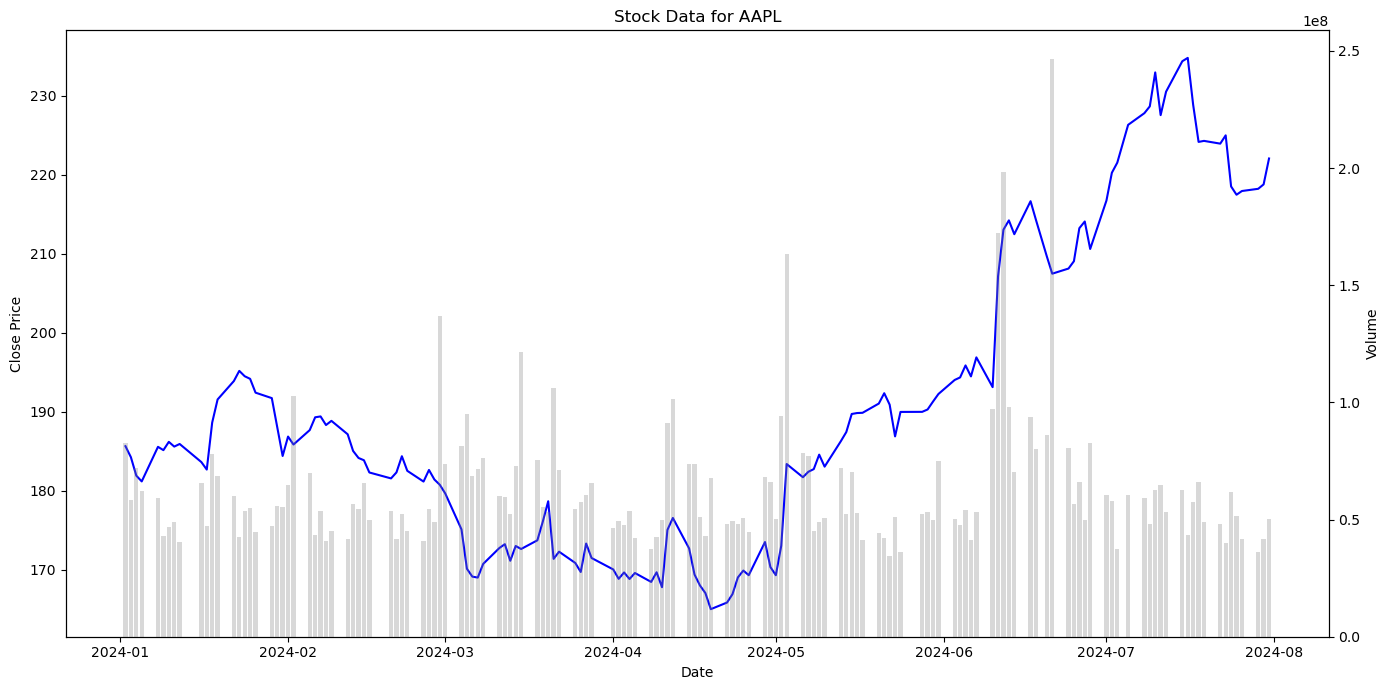

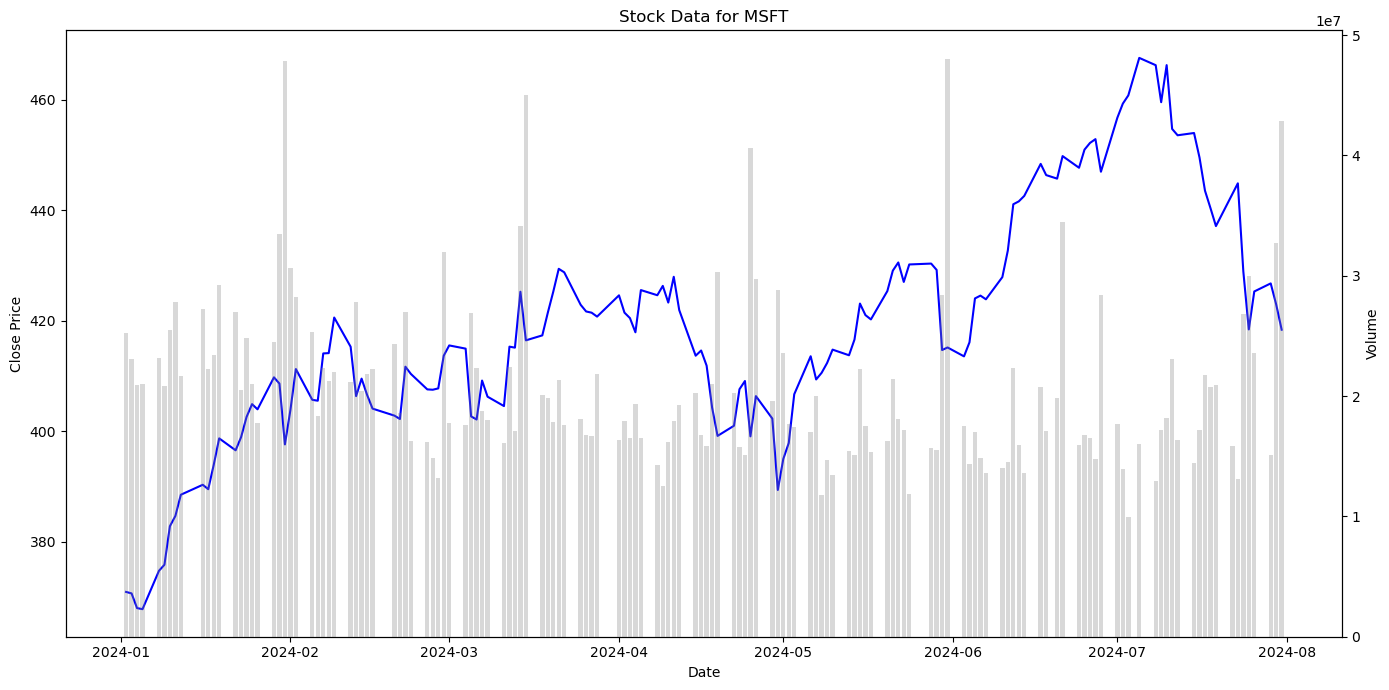

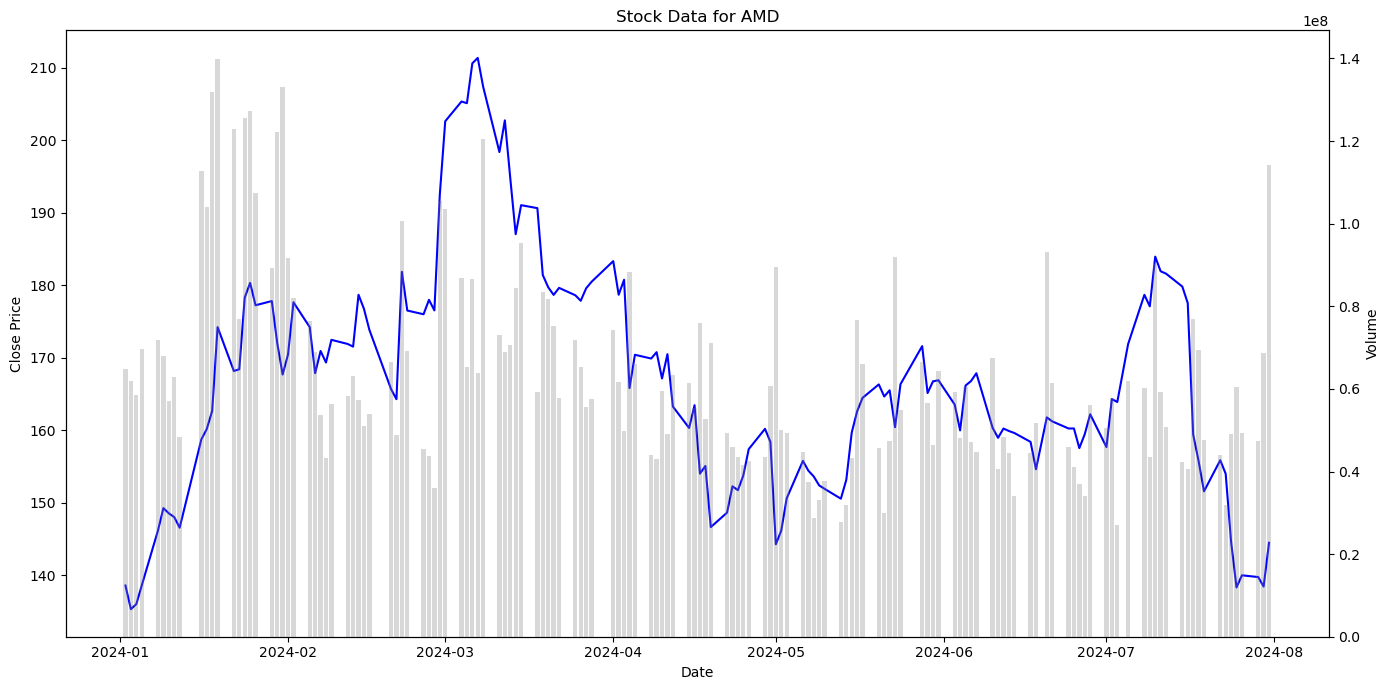

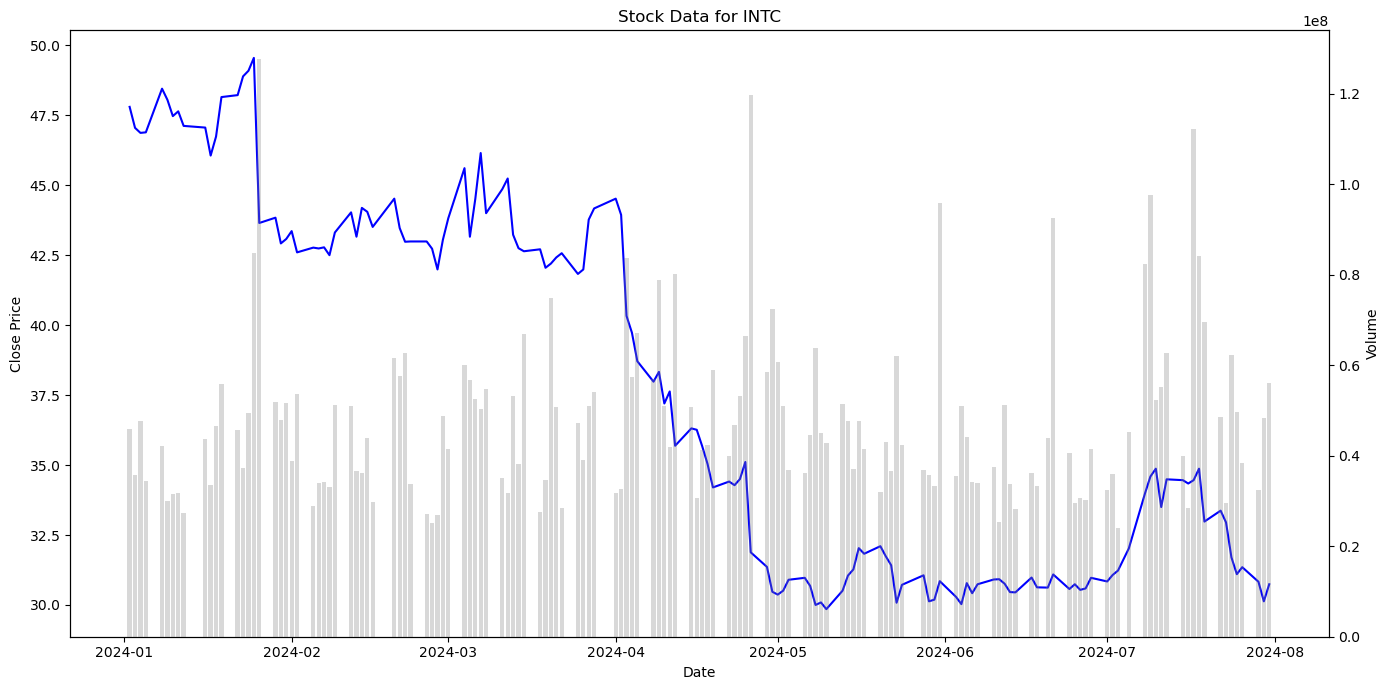

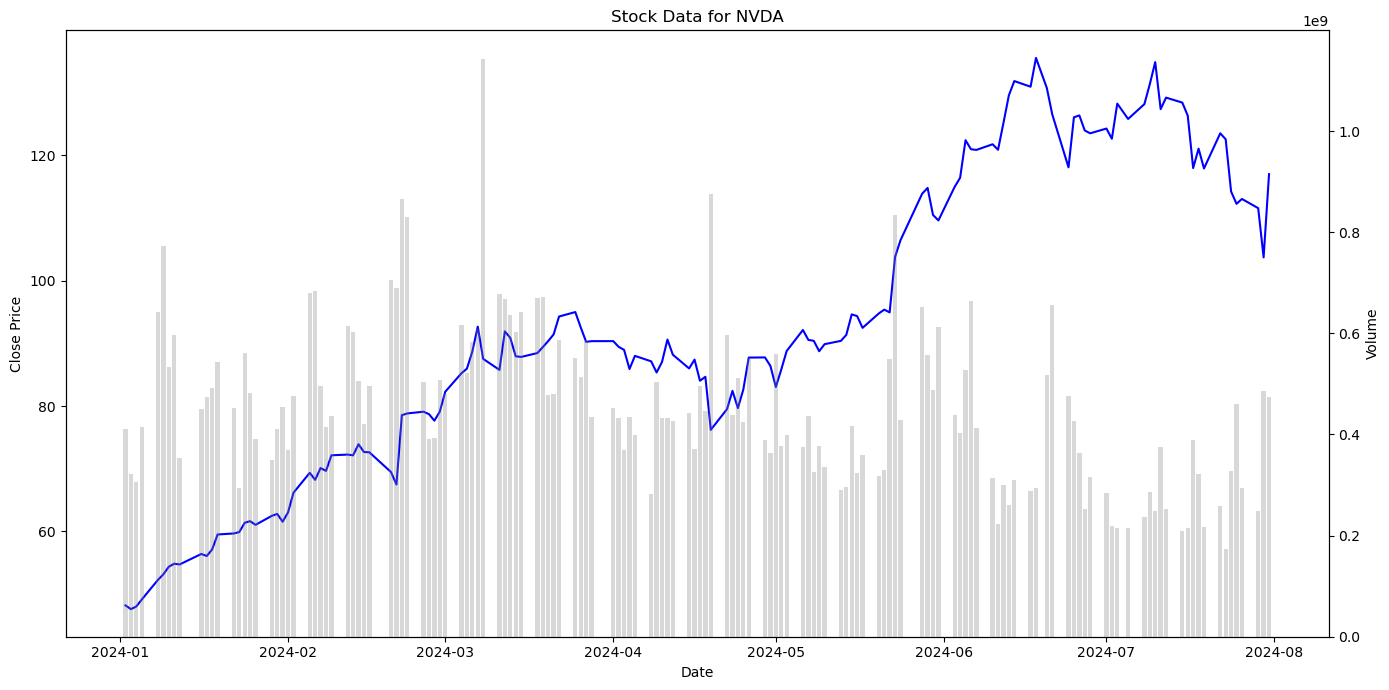

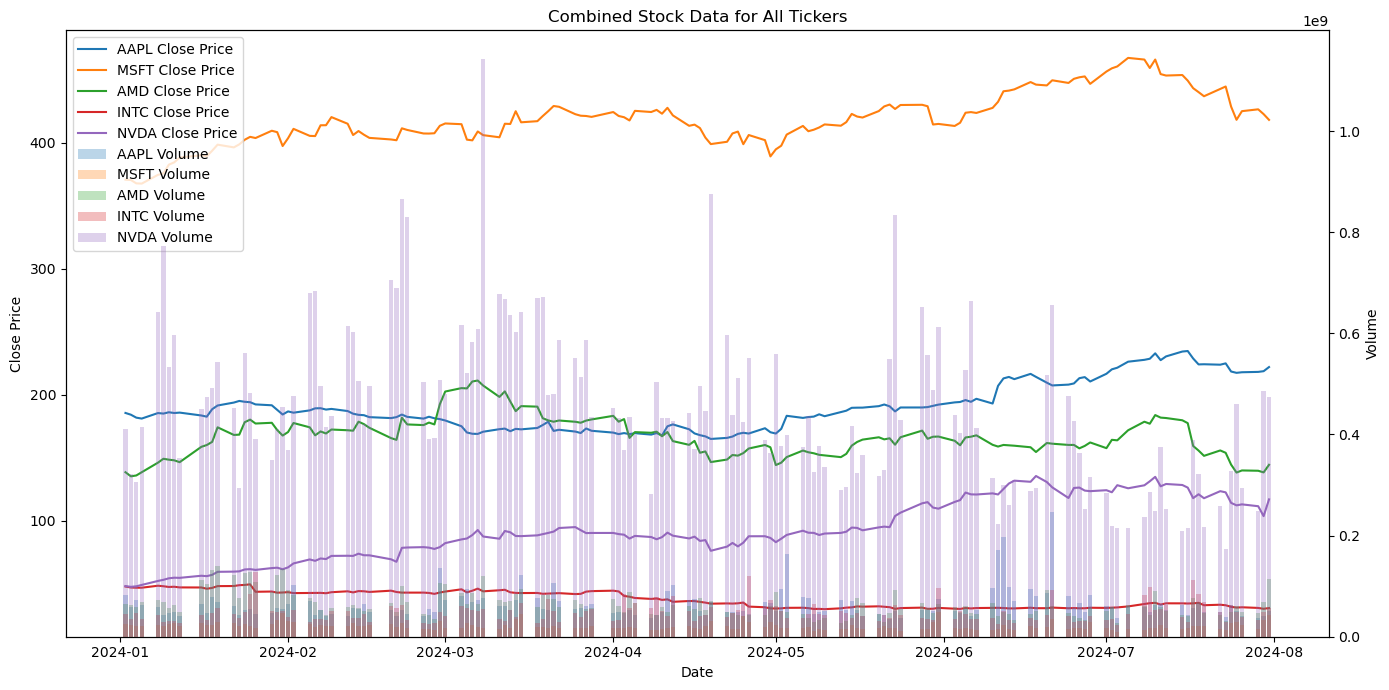

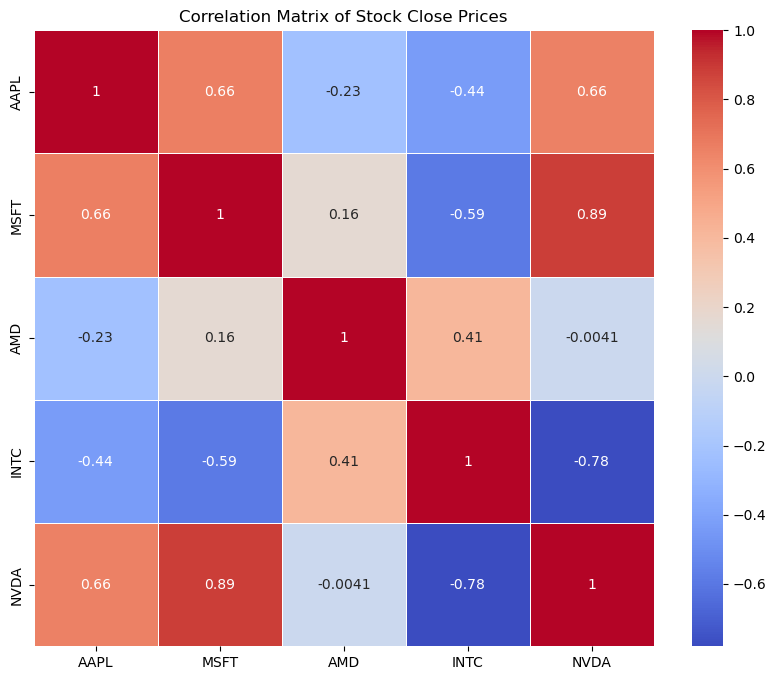

AAPL Volatility: 0.0153
MSFT Volatility: 0.0124
AMD Volatility: 0.0313
INTC Volatility: 0.0239
NVDA Volatility: 0.0350


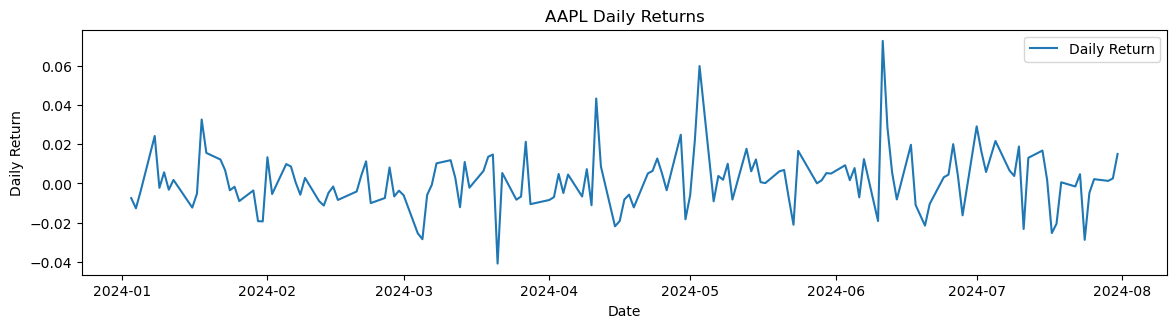

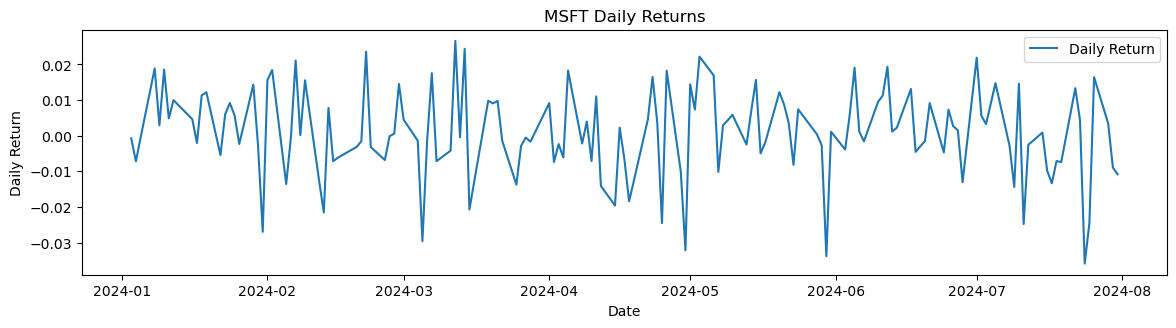

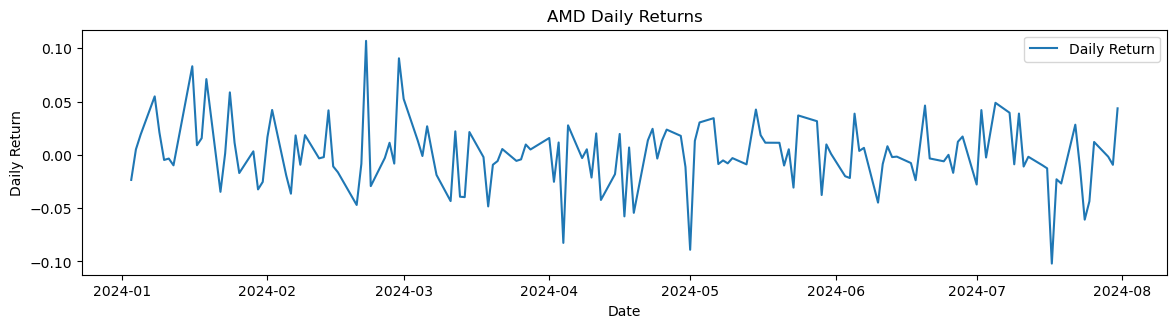

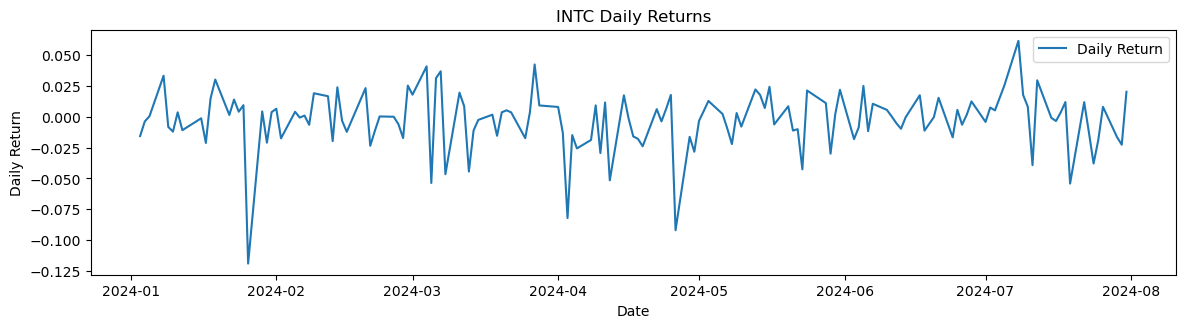

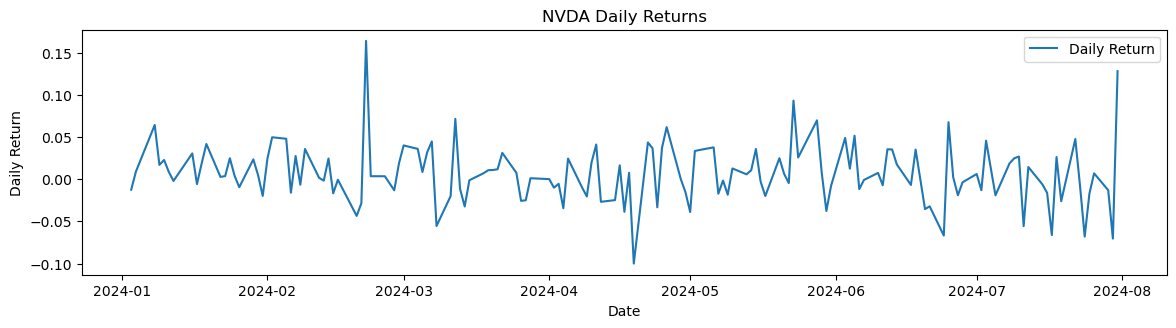

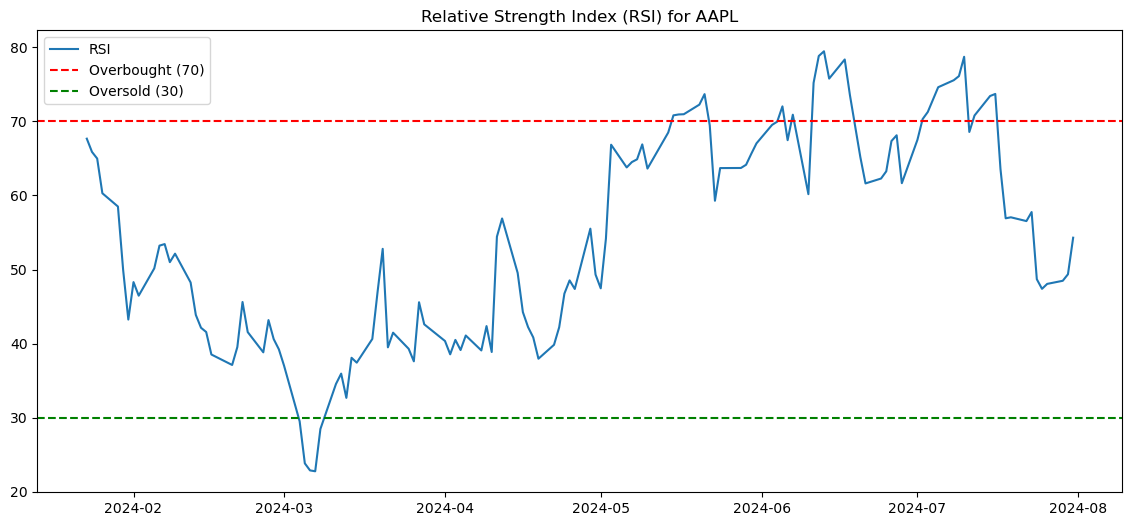

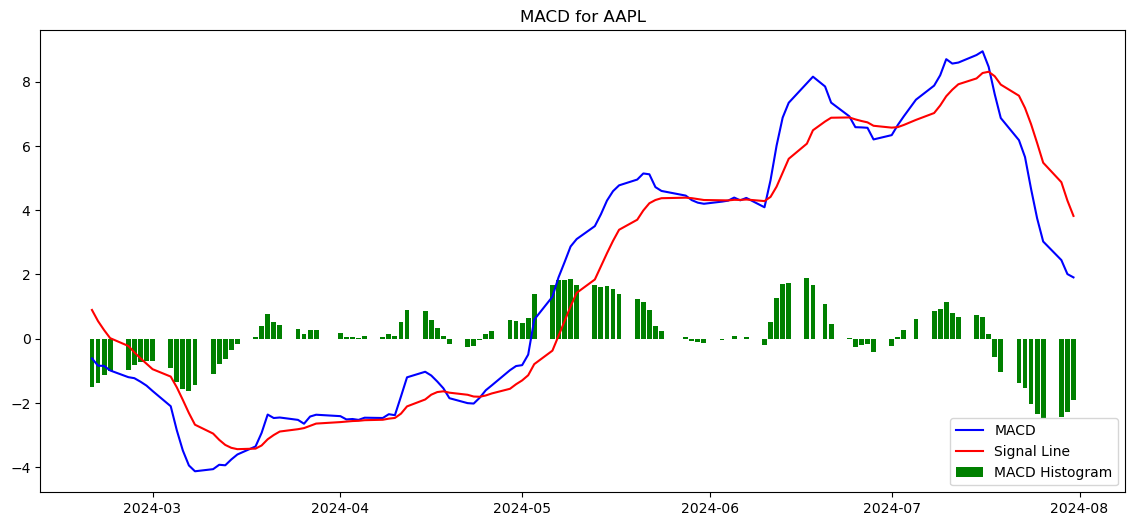

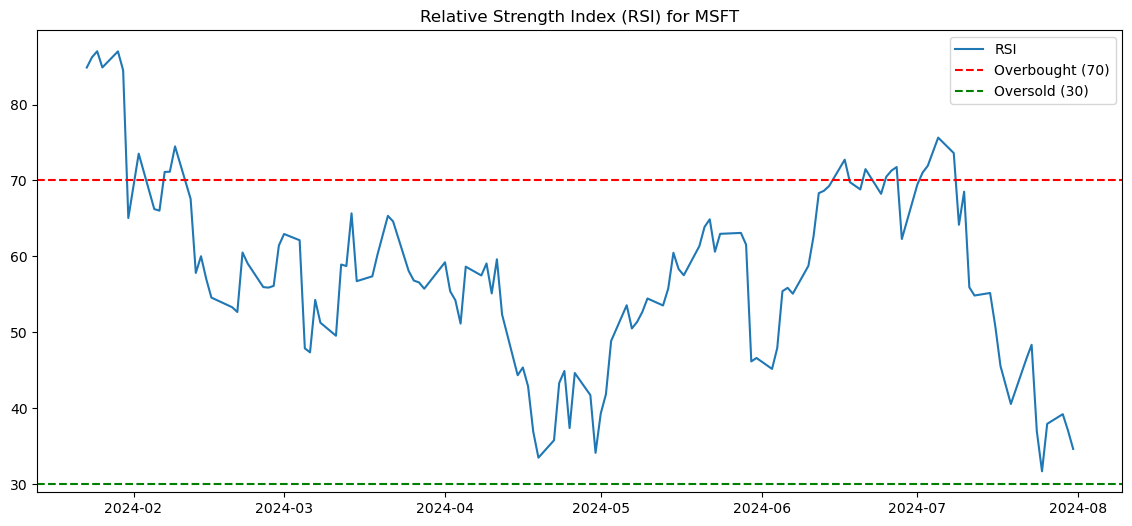

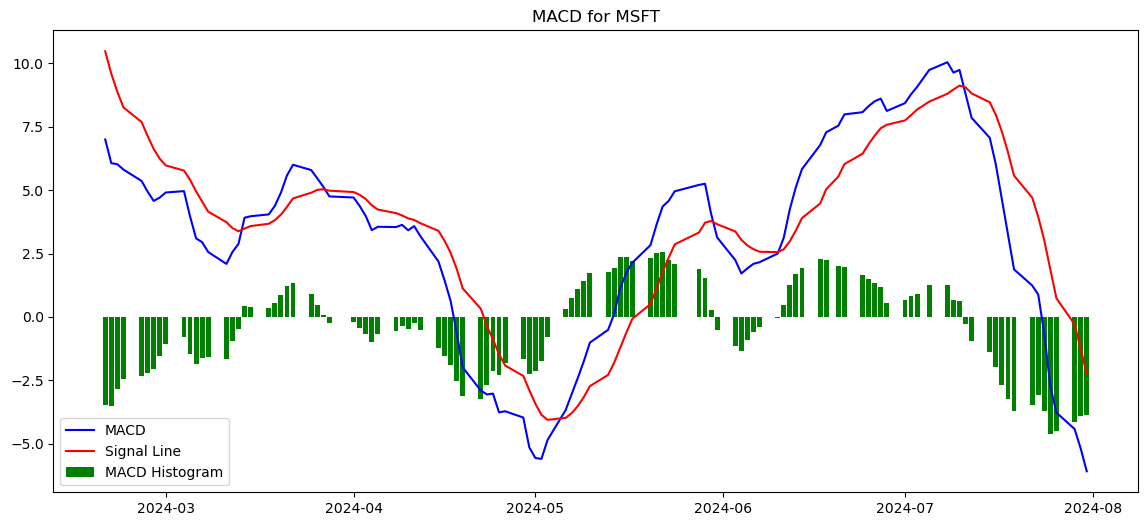

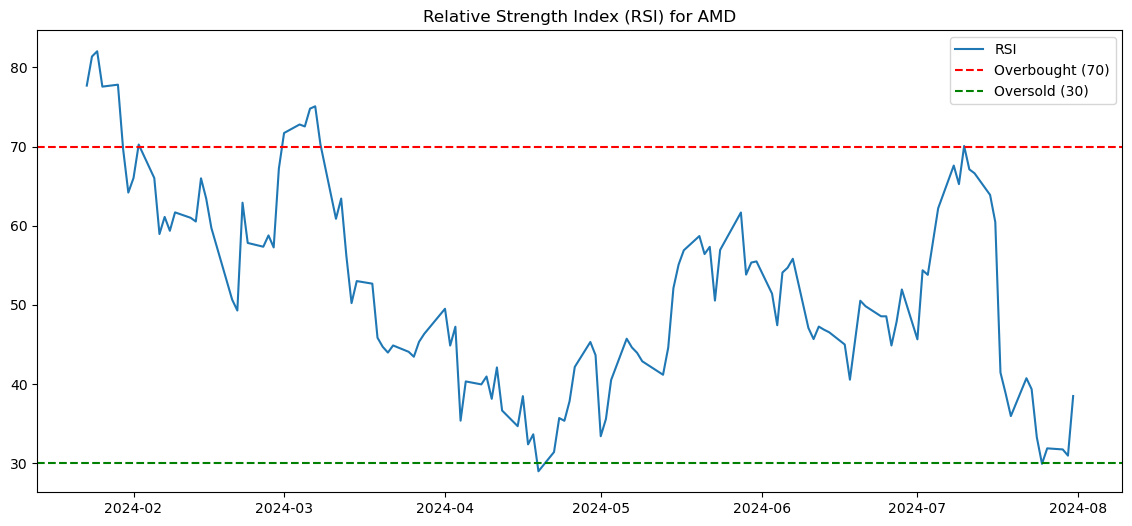

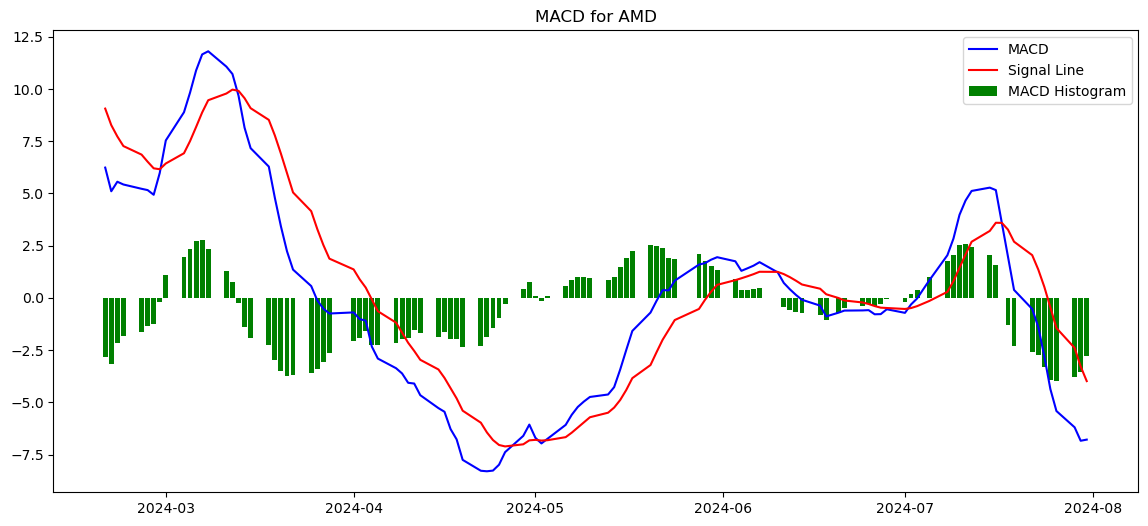

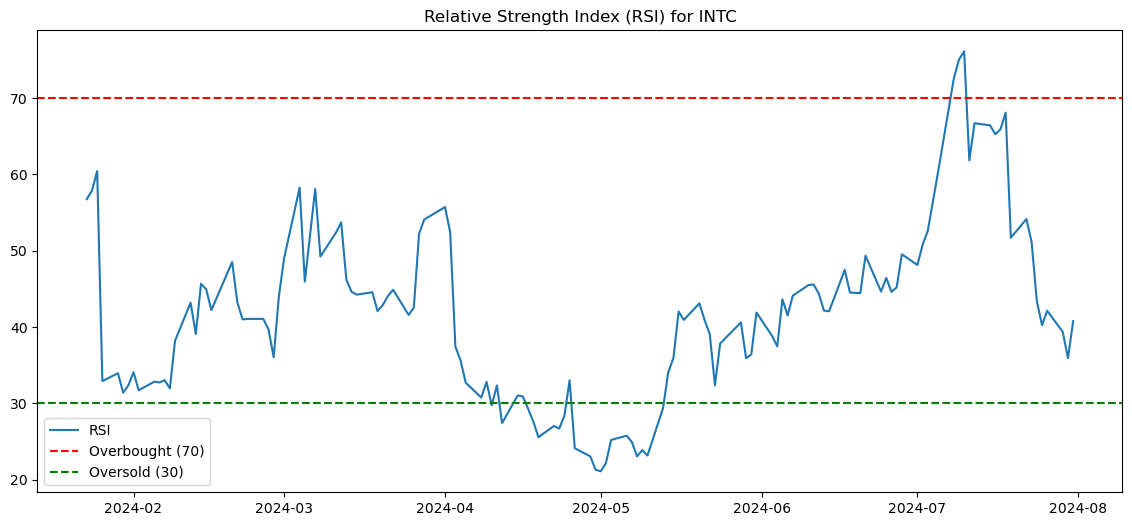

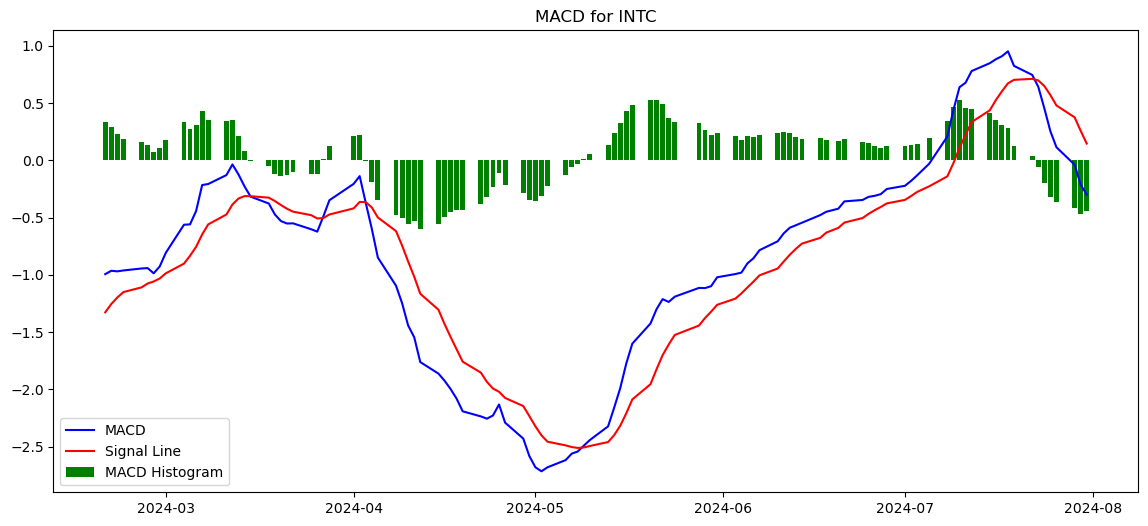

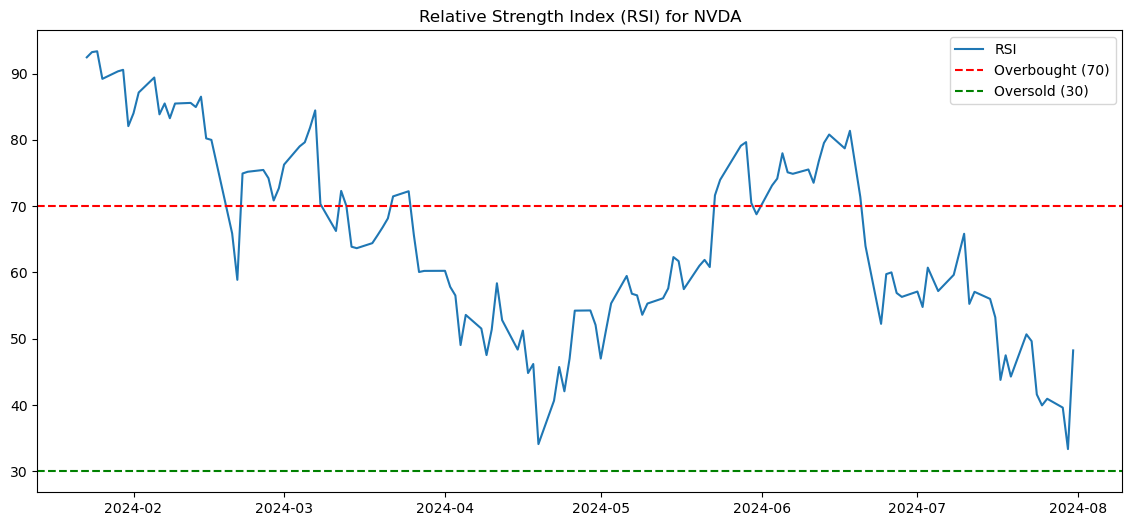

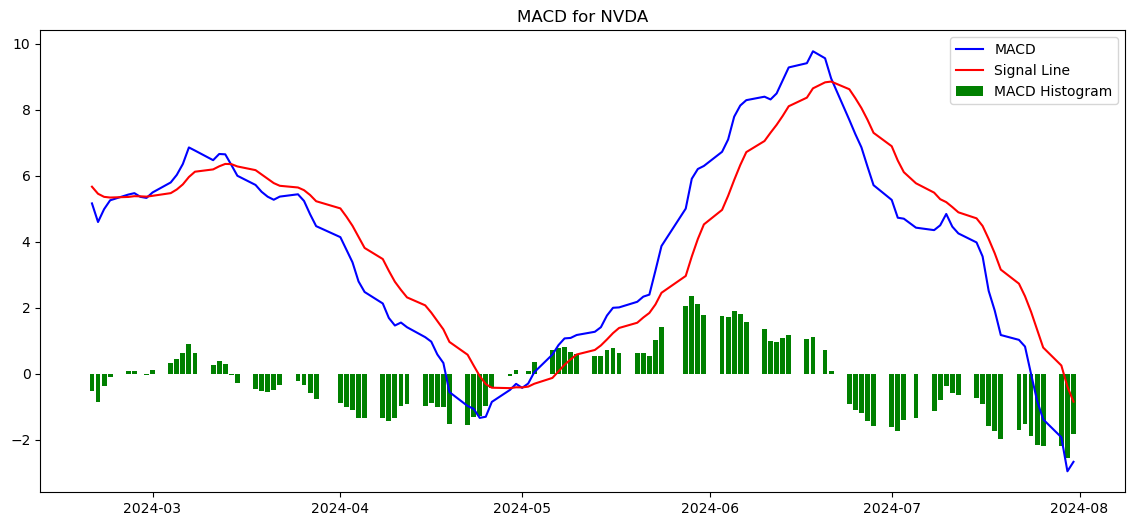

In [ ]:
top_label = widgets.Label(value="Search securities by name or tickers and add them to a visualization list. Select 3-5 securities for at least 6 months period for better visualizations.")
text_filter = widgets.Text(placeholder='Search by ticker or name')
filtered_list = widgets.SelectMultiple()
filtered_list.layout = widgets.Layout(width='500px') 
add_button = widgets.Button(description="Add")
clear_button = widgets.Button(description="Clear List")
visualizations_label = widgets.Label(value="Visualizations Tickers List")
final_list = widgets.SelectMultiple()
final_list.layout = widgets.Layout(width='500px')
start_date = widgets.DatePicker(description='Start Date')
end_date = widgets.DatePicker(description='End Date')
retrieve_button = widgets.Button(description="Visualize!")

def filter_securities(change):
    search_term = change['new'].lower()
    if search_term:
        # Filter only the rows that contain the search term in either the Symbol or Security Name columns
        filtered = securities[
            securities['Symbol'].str.contains(search_term, case=False) | 
            securities['Security Name'].str.contains(search_term, case=False)
        ]
        filtered_list.options = [f"{row['Symbol']}, {row['Security Name']}" for _, row in filtered.iterrows()]
    else:
        filtered_list.options = []

def add_to_final_list(b):
    current_final_list = list(final_list.options)
    for item in filtered_list.value:
        if item not in current_final_list:
            current_final_list.append(item)
    final_list.options = current_final_list
    filtered_list.value = []

def clear_final_list(b):
    final_list.options = []

text_filter.observe(filter_securities, names='value')
add_button.on_click(add_to_final_list)
clear_button.on_click(clear_final_list)

def on_retrieve_click(b):
    selected_tickers = [item.split(',', 1)[0] for item in final_list.options]
    start = start_date.value
    end = end_date.value
    today = date.today()
    
    if start and end:
        if start > end:
            clear_output()
            display(top_label, text_filter, filtered_list, add_button, clear_button, visualizations_label, final_list, start_date, end_date, retrieve_button)
            display("Error: Start date must be before the end date.")
            return
        if start >= today or end >= today:
            clear_output()
            display(top_label, text_filter, filtered_list, add_button, clear_button, visualizations_label, final_list, start_date, end_date, retrieve_button)
            display("Error: Dates can only be in the past (today is forbidden as well.")
            return

    if selected_tickers and start and end:
        clear_output()
        display(top_label, text_filter, filtered_list, add_button, clear_button, visualizations_label, final_list, start_date, end_date, retrieve_button)
        print("Selected tickers:", selected_tickers)
        print("Start Date:", start)
        print("End Date:", end)
        ticker_to_stock_prices = download_prices_of_securities(selected_tickers, start, end)
        show_visualizations(ticker_to_stock_prices)
    else:
        clear_output()
        display(top_label, text_filter, filtered_list, add_button, clear_button, visualizations_label, final_list, start_date, end_date, retrieve_button)
        display("Please make sure to select tickers and dates.")

retrieve_button.on_click(on_retrieve_click)

display(top_label, text_filter, filtered_list, add_button, clear_button, visualizations_label, final_list, start_date, end_date, retrieve_button)